In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

%matplotlib inline

In [3]:
label_df = pd.read_csv("./data/labels.csv").dropna()

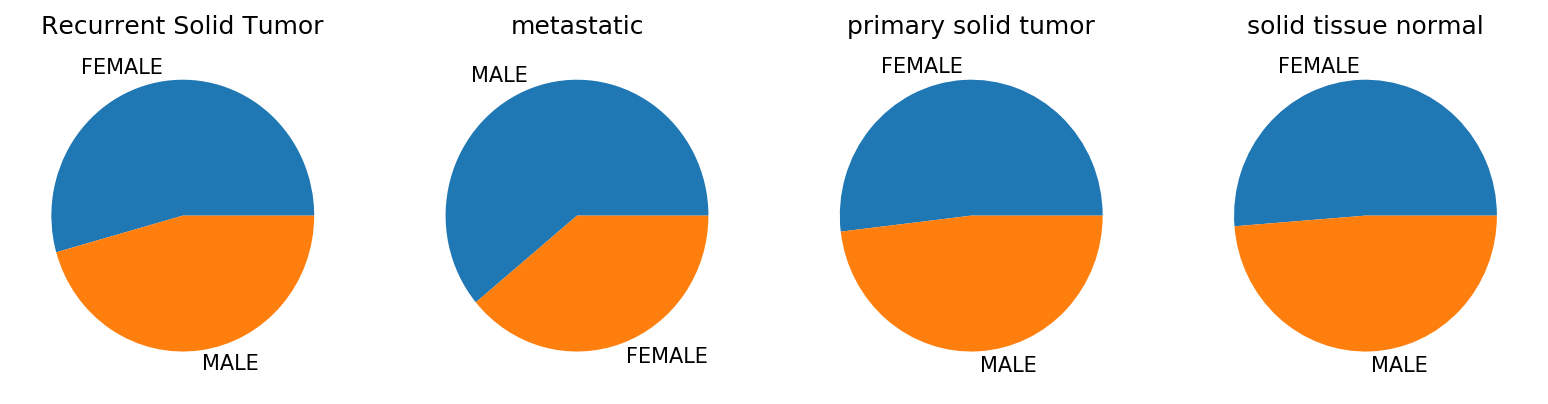

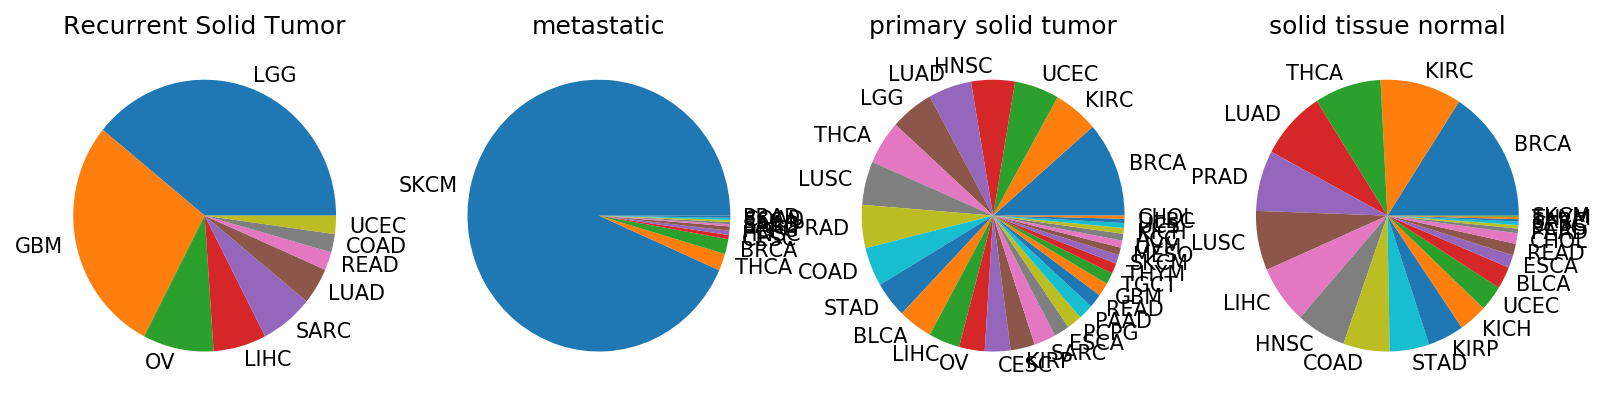

In [5]:
for pie_chart_label in ["label_gender", "label_tissue"]:
    fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(13,3), dpi=150)
    for i, tumor_type in enumerate(set(label_df.label_tumor)):
        this_tumor = label_df[label_df.label_tumor==tumor_type].copy()
        ax = this_tumor[pie_chart_label].value_counts(normalize=True).plot.pie(ax=axes[i])
        axes[i].set_ylabel("")
        axes[i].set_title(tumor_type)
    plt.show()